In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
file_path = r'C:\Users\harjee\Downloads\Online Retail.xlsx'
df = pd.read_excel(file_path)
df.head(10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [22]:
## 3. Data Cleaning
# Cleaning
df = df.dropna(subset=["CustomerID"])
df = df[df["Quantity"] > 0]
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Show unique invoice numbers that remain after cleaning
invoice_list = df["InvoiceNo"].unique()
print(f"Total cleaned invoices: {len(invoice_list)}")
print(invoice_list)



Total cleaned invoices: 18536
[536365 536366 536367 ... 581585 581586 581587]


In [21]:
## 4. Feature Engineering (RFM + Transaction Features)
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                  # Frequency
    "TotalPrice": "sum",                                     # Monetary
    "Quantity": "mean",                                      # Avg basket size
    "UnitPrice": "mean"                                      # Avg unit price
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary", "AvgBasketSize", "AvgUnitPrice"]

# Show the first 5 rows
rfm.head()



,CustomerID,Recency,Frequency,Monetary,AvgBasketSize,AvgUnitPrice
0,12346.0,326,1,77183.60,74215.000000,1.040000
1,12347.0,2,7,4310.00,13.505495,2.644011
2,12348.0,75,4,1797.24,75.516129,5.764839
3,12349.0,19,1,1757.55,8.643836,8.289041
4,12350.0,310,1,334.40,11.588235,3.841176


In [20]:
## 5. Standardization

features = ["Recency", "Frequency", "Monetary", "AvgBasketSize", "AvgUnitPrice"]
X = rfm[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ask user for start and end rows
start = int(input("Enter the starting row index: "))
end = int(input("Enter the ending row index: "))

# Display selected range
pd.DataFrame(X_scaled, columns=features).iloc[start:end]

Enter the starting row index:  375
Enter the ending row index:  384


,Recency,Frequency,Monetary,AvgBasketSize,AvgUnitPrice
375,-0.175186,0.094495,-0.032746,-0.001595,0.093112
376,-0.325189,-0.424675,-0.184337,-0.031742,-0.056417
377,-0.895199,0.354080,-0.064433,-0.029815,-0.074190
378,-0.865199,-0.165090,-0.180661,-0.032891,-0.046699
379,-0.895199,0.224288,-0.115173,-0.032118,-0.040208
380,2.444860,-0.294882,-0.195922,-0.011297,0.172583
381,-0.545193,0.224288,0.529736,0.173409,-0.098790
382,1.694847,-0.424675,-0.204595,-0.027046,-0.040890
383,-0.605194,-0.294882,-0.185904,-0.033431,-0.044919


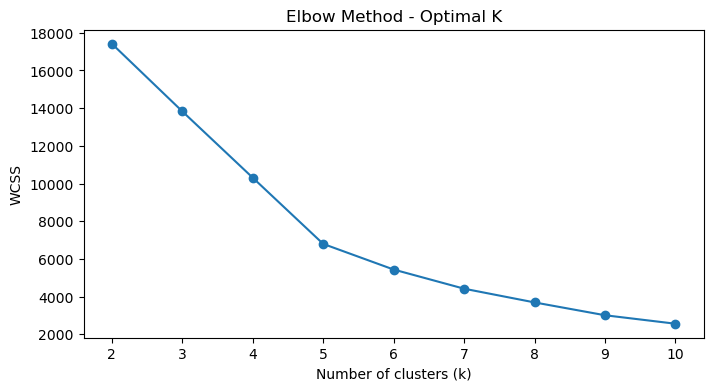

In [14]:
## 6. Optimal Number of Clusters (Elbow Method

wcss = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, wcss, marker="o")
plt.title("Elbow Method - Optimal K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.show()


In [17]:
## 7. Validation with Silhouette Score

k_start = int(input("Enter the starting value of k: "))
k_end = int(input("Enter the ending value of k: "))

for k in range(k_start, k_end + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for k={k}: {score:.3f}")


Enter the starting value of k:  355
Enter the ending value of k:  375


Silhouette Score for k=355: 0.282
Silhouette Score for k=356: 0.283
Silhouette Score for k=357: 0.285
Silhouette Score for k=358: 0.284
Silhouette Score for k=359: 0.284
Silhouette Score for k=360: 0.283
Silhouette Score for k=361: 0.284
Silhouette Score for k=362: 0.283
Silhouette Score for k=363: 0.283
Silhouette Score for k=364: 0.283
Silhouette Score for k=365: 0.283
Silhouette Score for k=366: 0.278
Silhouette Score for k=367: 0.287
Silhouette Score for k=368: 0.281
Silhouette Score for k=369: 0.276
Silhouette Score for k=370: 0.276
Silhouette Score for k=371: 0.278
Silhouette Score for k=372: 0.281
Silhouette Score for k=373: 0.283
Silhouette Score for k=374: 0.282
Silhouette Score for k=375: 0.287


In [25]:
## 8. Run K-Means Clustering
from IPython.display import display

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(X_scaled)

# Show outputs
display(rfm[["CustomerID", "Cluster"]].head(10))
display(rfm["Cluster"].value_counts().sort_index())
display(rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary", "AvgBasketSize", "AvgUnitPrice"]].mean())



,CustomerID,Cluster
0,12346.0,1
1,12347.0,0
2,12348.0,0
3,12349.0,0
4,12350.0,2
5,12352.0,0
6,12353.0,2
7,12354.0,2
8,12355.0,2
9,12356.0,0


Cluster
0    3224
1       1
2    1088
3      26
Name: count, dtype: int64

,Recency,Frequency,Monetary,AvgBasketSize,AvgUnitPrice
Cluster,,,,,
0,41.263027,4.678970,1856.548469,23.153293,3.444867
1,326.000000,1.000000,77183.600000,74215.000000,1.040000
2,246.251838,1.581801,565.440166,27.448622,7.500839
3,6.038462,66.500000,85904.351538,1126.763446,4.097863


In [26]:
## 9. Cluster Profiling
cluster_summary = rfm.groupby("Cluster")[features].mean()
cluster_summary

,Recency,Frequency,Monetary,AvgBasketSize,AvgUnitPrice
Cluster,,,,,
0,41.263027,4.678970,1856.548469,23.153293,3.444867
1,326.000000,1.000000,77183.600000,74215.000000,1.040000
2,246.251838,1.581801,565.440166,27.448622,7.500839
3,6.038462,66.500000,85904.351538,1126.763446,4.097863


In [29]:
## 10. Visualization of Clusters

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(X_scaled)

# Add cluster labels to original cleaned dataset
df["Cluster"] = rfm.set_index("CustomerID")["Cluster"]

print("Cluster labels added to both RFM table and original dataset ✅")
rfm[["CustomerID", "Cluster"]].head()




Cluster labels added to both RFM table and original dataset ✅


,CustomerID,Cluster
0,12346.0,1
1,12347.0,0
2,12348.0,0
3,12349.0,0
4,12350.0,2


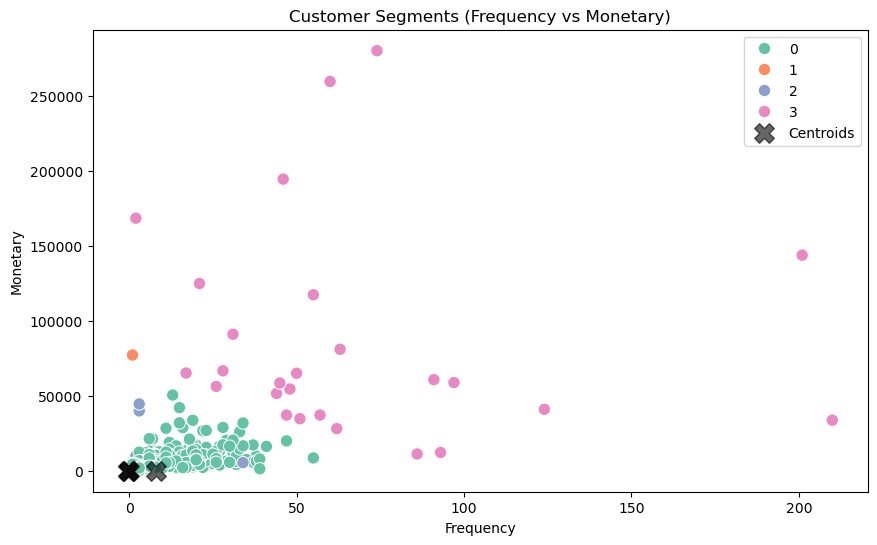

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Frequency", y="Monetary", 
    hue="Cluster", data=rfm, palette="Set2", s=80
)

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, features.index("Frequency")], 
    centroids[:, features.index("Monetary")],
    c="black", s=200, alpha=0.6, marker="X", label="Centroids"
)

plt.title("Customer Segments (Frequency vs Monetary)")
plt.legend()
plt.show()


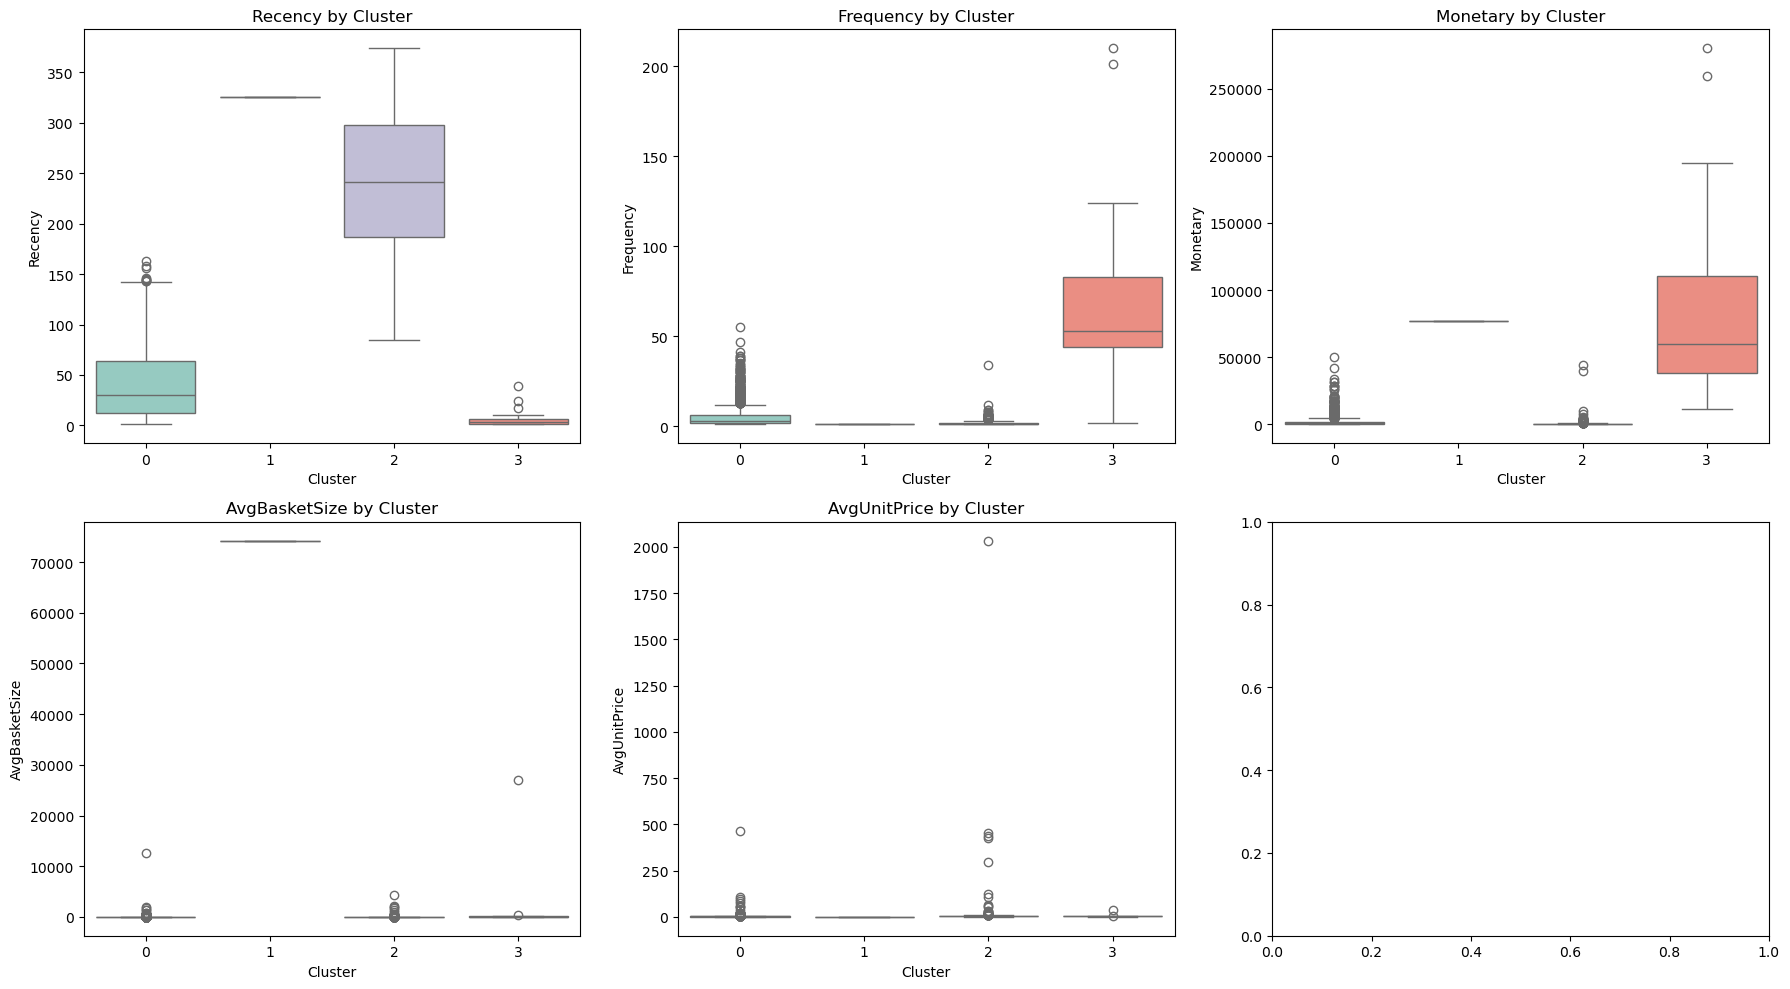

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x="Cluster", y=feature, hue="Cluster", data=rfm, palette="Set3", legend=False, ax=axes[i])
    axes[i].set_title(f"{feature} by Cluster")

plt.tight_layout()
plt.show()



In [35]:
cluster_summary = rfm.groupby("Cluster")[features].agg(["mean", "median", "std"]).round(2)
cluster_summary


Recency               Frequency                Monetary            \
           mean median    std      mean median    std      mean    median   
Cluster                                                                     
0         41.26   30.0  35.29      4.68    3.0   5.15   1856.55    917.77   
1        326.00  326.0    NaN      1.00    1.0    NaN  77183.60  77183.60   
2        246.25  241.0  67.41      1.58    1.0   1.45    565.44    311.13   
3          6.04    3.5   8.60     66.50   53.0  49.25  85904.35  59796.87   

                  AvgBasketSize                    AvgUnitPrice                
              std          mean    median      std         mean median    std  
Cluster                                                                        
0         3058.70         23.15     10.28   231.92         3.44   2.85   9.06  
1             NaN      74215.00  74215.00      NaN         1.04   1.04    NaN  
2         1909.87         27.45      8.95   176.91         7.50   3.24  66.43  
3        70812.11       1126.76     70.19  5277.80         4.10   2.55   6.61

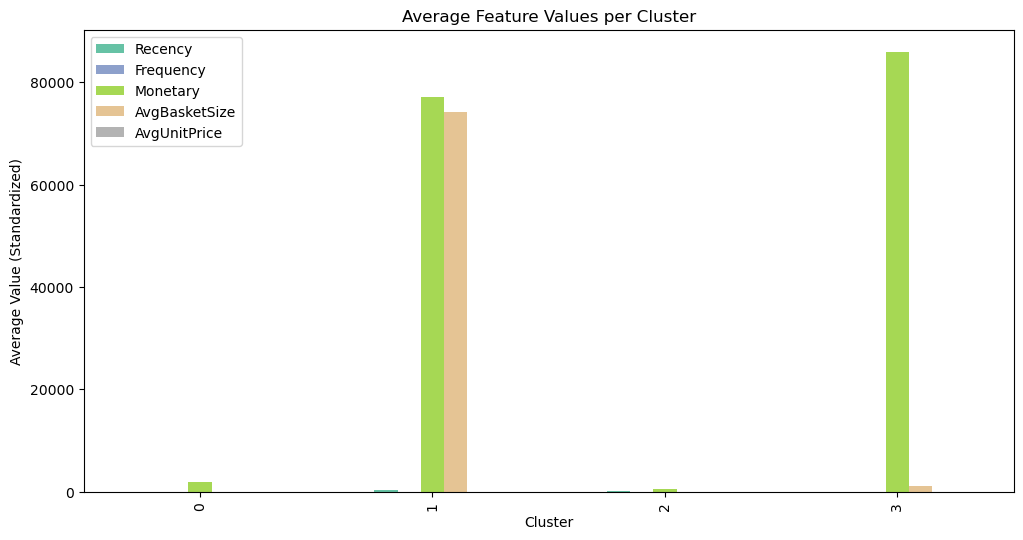

In [36]:
profile = rfm.groupby("Cluster")[features].mean().round(2)

profile.plot(kind="bar", figsize=(12, 6), colormap="Set2")
plt.title("Average Feature Values per Cluster")
plt.ylabel("Average Value (Standardized)")
plt.show()
